In [1]:
import os                          # Access system file-tree
import sys                         # Modify system parameters

import numpy as np                 # Data structures
import pandas as pd                # Data structures

import matplotlib.ticker as mticker  # Scientific notation in labels
from matplotlib.ticker import FuncFormatter

# Global options for external dependencies
np.set_printoptions(threshold=sys.maxsize, precision=16)

In [2]:
# Internal Dependencies
internalPath = os.getcwd() + "/../python"
print(internalPath)
sys.path.insert(0, internalPath)

from plotStyling import PlotStyling  # noqa: E402
from simulationDataLoad import gsd_df, find_compressed_data, load_compressed_data, parse_loaded_data

/home/aglisman/Dropbox/3_Brady_Lab/Code/potential-flow/bodies-in-potential-flow/jupyter_notebooks/../python


In [3]:
# Simulation parameters
data_source = ["v1.0.0_output_last_frame", "v1.5.1", "v1.6.2"]
parameters_varied = ["varyRelDisp", "varyZHeight"]

# Plotting parameters
eps_output = True

# Paths
cwd = os.getcwd()
relative_path_base = [cwd + "/../data_tag/" + d for d in data_source]
output_dir = cwd + "/internal_dynamics_comparison"

In [4]:
# Correctly get scientific notation in text elements
def scientific(x, pos):
    return '%0.2e' % x


scientific_formatter = FuncFormatter(scientific)
fmt = mticker.FuncFormatter(scientific_formatter)

In [5]:
# Data output parameters
saved_data_file = output_dir + "/data.pkl"

# Try making output dir if not exists
try:
    os.mkdir(output_dir)
except FileExistsError:
    pass

# Load data from source or pickle
if os.path.exists(saved_data_file):
    all_data_df = pd.read_pickle(saved_data_file, compression='xz')
else:
    all_data_df = gsd_df(relative_path_base, parameters_varied)
    all_data_df.to_pickle(saved_data_file, compression='xz')

In [6]:
# Preview data
print((len(all_data_df)))
all_data_df.head(1)

183


,gsd_path,CoM_disp,CoM_disp_x,CoM_disp_y,CoM_disp_z,R_avg,Z_0,phase_shift,U0,omega,...,final_time,final_positions,final_velocities,final_accelerations,q,q0,theta,theta_dot,theta_ddot,final_theta
0,/home/aglisman/Dropbox/3_Brady_Lab/Code/potent...,0.61661,0.61661,1.566018e-18,-4.087713e-18,2.0007,0.0,-1.570796,1.0,1.0,...,1.0,"[[2.617309772294328, -1.9273344734696485e-18, ...","[[0.6713793604950071, -9.035925365185449e-19, ...","[[-0.3655585789461922, -5.2030872641112235e-17...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[1.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0


In [7]:
# split data into system types
collinear_swimmer_isolated_df = all_data_df.loc[all_data_df['gsd_path'].str.contains(
    "v1.0.0", case=False, regex=False)]
collinear_swimmer_wall_df = all_data_df.loc[all_data_df['gsd_path'].str.contains(
    "v1.5.1", case=False, regex=False)]
collinear_swimmer_wall_no_int_dyn_df = all_data_df.loc[all_data_df['gsd_path'].str.contains(
    "v1.6.2", case=False, regex=False)]

# split data further into varyZHeight
csi_vary_rel_disp = collinear_swimmer_isolated_df.loc[collinear_swimmer_isolated_df['gsd_path'].str.contains(
    "varyRelDisp", case=False, regex=False)]
csw_vary_z = collinear_swimmer_wall_df.loc[collinear_swimmer_wall_df['gsd_path'].str.contains(
    "varyZ", case=False, regex=False)]
csw_noint_vary_z = collinear_swimmer_wall_no_int_dyn_df.loc[collinear_swimmer_wall_no_int_dyn_df['gsd_path'].str.contains(
    "varyZ", case=False, regex=False)]

In [8]:
# Get parameters from wall problem
print(csw_vary_z["R_avg"].describe())

# Match with parameters from isolated case
csi_comparison = csi_vary_rel_disp.loc[csi_vary_rel_disp['R_avg'] == 4.0]
csi_com = np.array(csi_comparison['CoM_disp'])
csi_com_t25 = 25.0 * csi_com
print(csi_com_t25)

csi_U0 = csi_com / (2.0 * np.pi)
print(csi_U0)

count    12.0
mean      4.0
std       0.0
min       4.0
25%       4.0
50%       4.0
75%       4.0
max       4.0
Name: R_avg, dtype: float64
[0.3185964479904887]
[0.0020282479819682]


/home/aglisman/anaconda3/envs/bodies-in-potential-flow/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


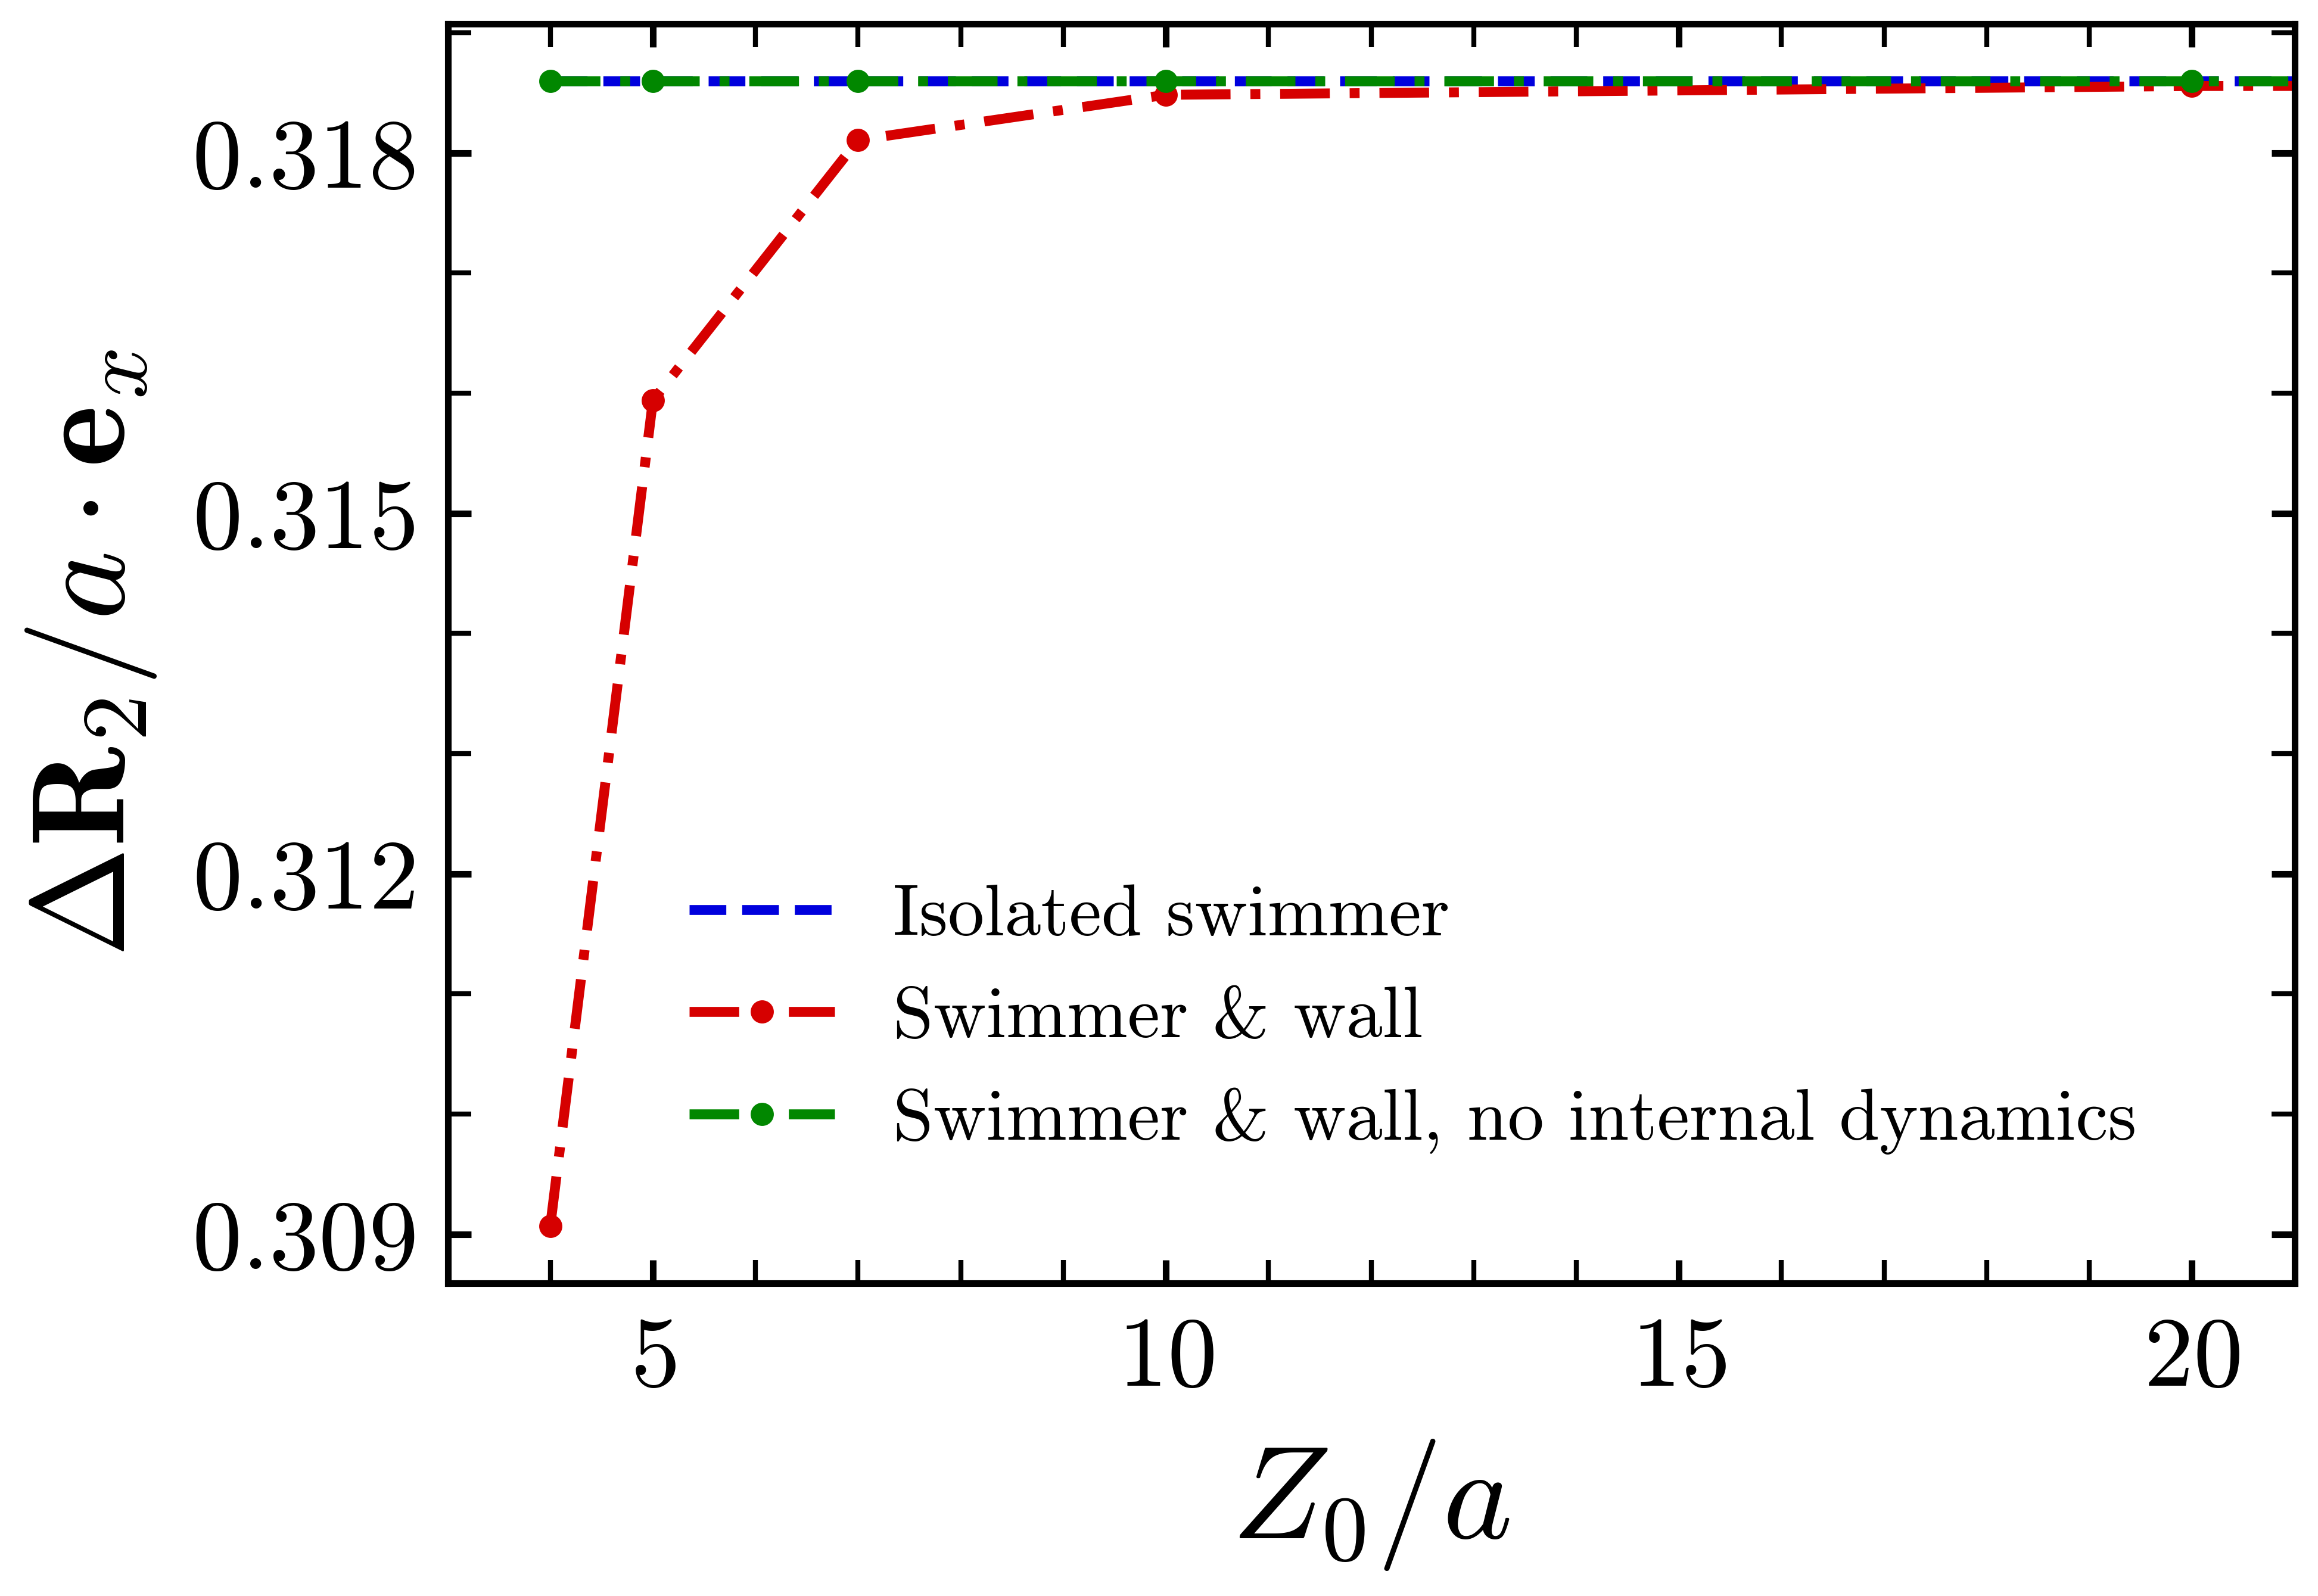

In [9]:
# Prepare data for plot
csw_noint_vary_z.sort_values(by='Z_0', inplace=True)
csw_vary_z.sort_values(by='Z_0', inplace=True)

# PLOT: CoM displacement along x-axis (initial propulsion direction) for varying Z-height
numLines = 3
CoM_x_disp_plot = PlotStyling(numLines,
                            r"$Z_{0} / a$", r"$\Delta \mathbf{R}_{2}/a \cdot \mathbf{e}_{x}$",
                            title=None, loglog=False,
                            outputDir=output_dir + '/', figName="com_x_disp_comp",
                            eps=eps_output, continuousColors=False)
CoM_x_disp_plot.make_plot(showPlot=True)
CoM_x_disp_plot.curve([4.0, 200.0], [csi_com_t25, csi_com_t25],
        thin_curve=False, dashed_curve=True, zorder=0, label="Isolated swimmer")
CoM_x_disp_plot.scatter_dashed(csw_vary_z['Z_0'], csw_vary_z['CoM_disp_x'], 
        marker=None, zorder=1, label="Swimmer & wall")
CoM_x_disp_plot.scatter_dashed(csw_noint_vary_z['Z_0'], csw_noint_vary_z['CoM_disp_x'], 
        marker=None, zorder=2, label="Swimmer & wall, no internal dynamics")
CoM_x_disp_plot.set_major_minor_ticks(xMajorLoc=5, xMinorLoc=1, yMajorLoc=0.003, yMinorLoc=0.001)
CoM_x_disp_plot.ax.set_xlim([3, 21])
CoM_x_disp_plot.legend(title=None, loc='best', bbox_to_anchor=(0.05, 0.05, 0.9, 0.9), ncol=1)
CoM_x_disp_plot.save_plot()

/home/aglisman/anaconda3/envs/bodies-in-potential-flow/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


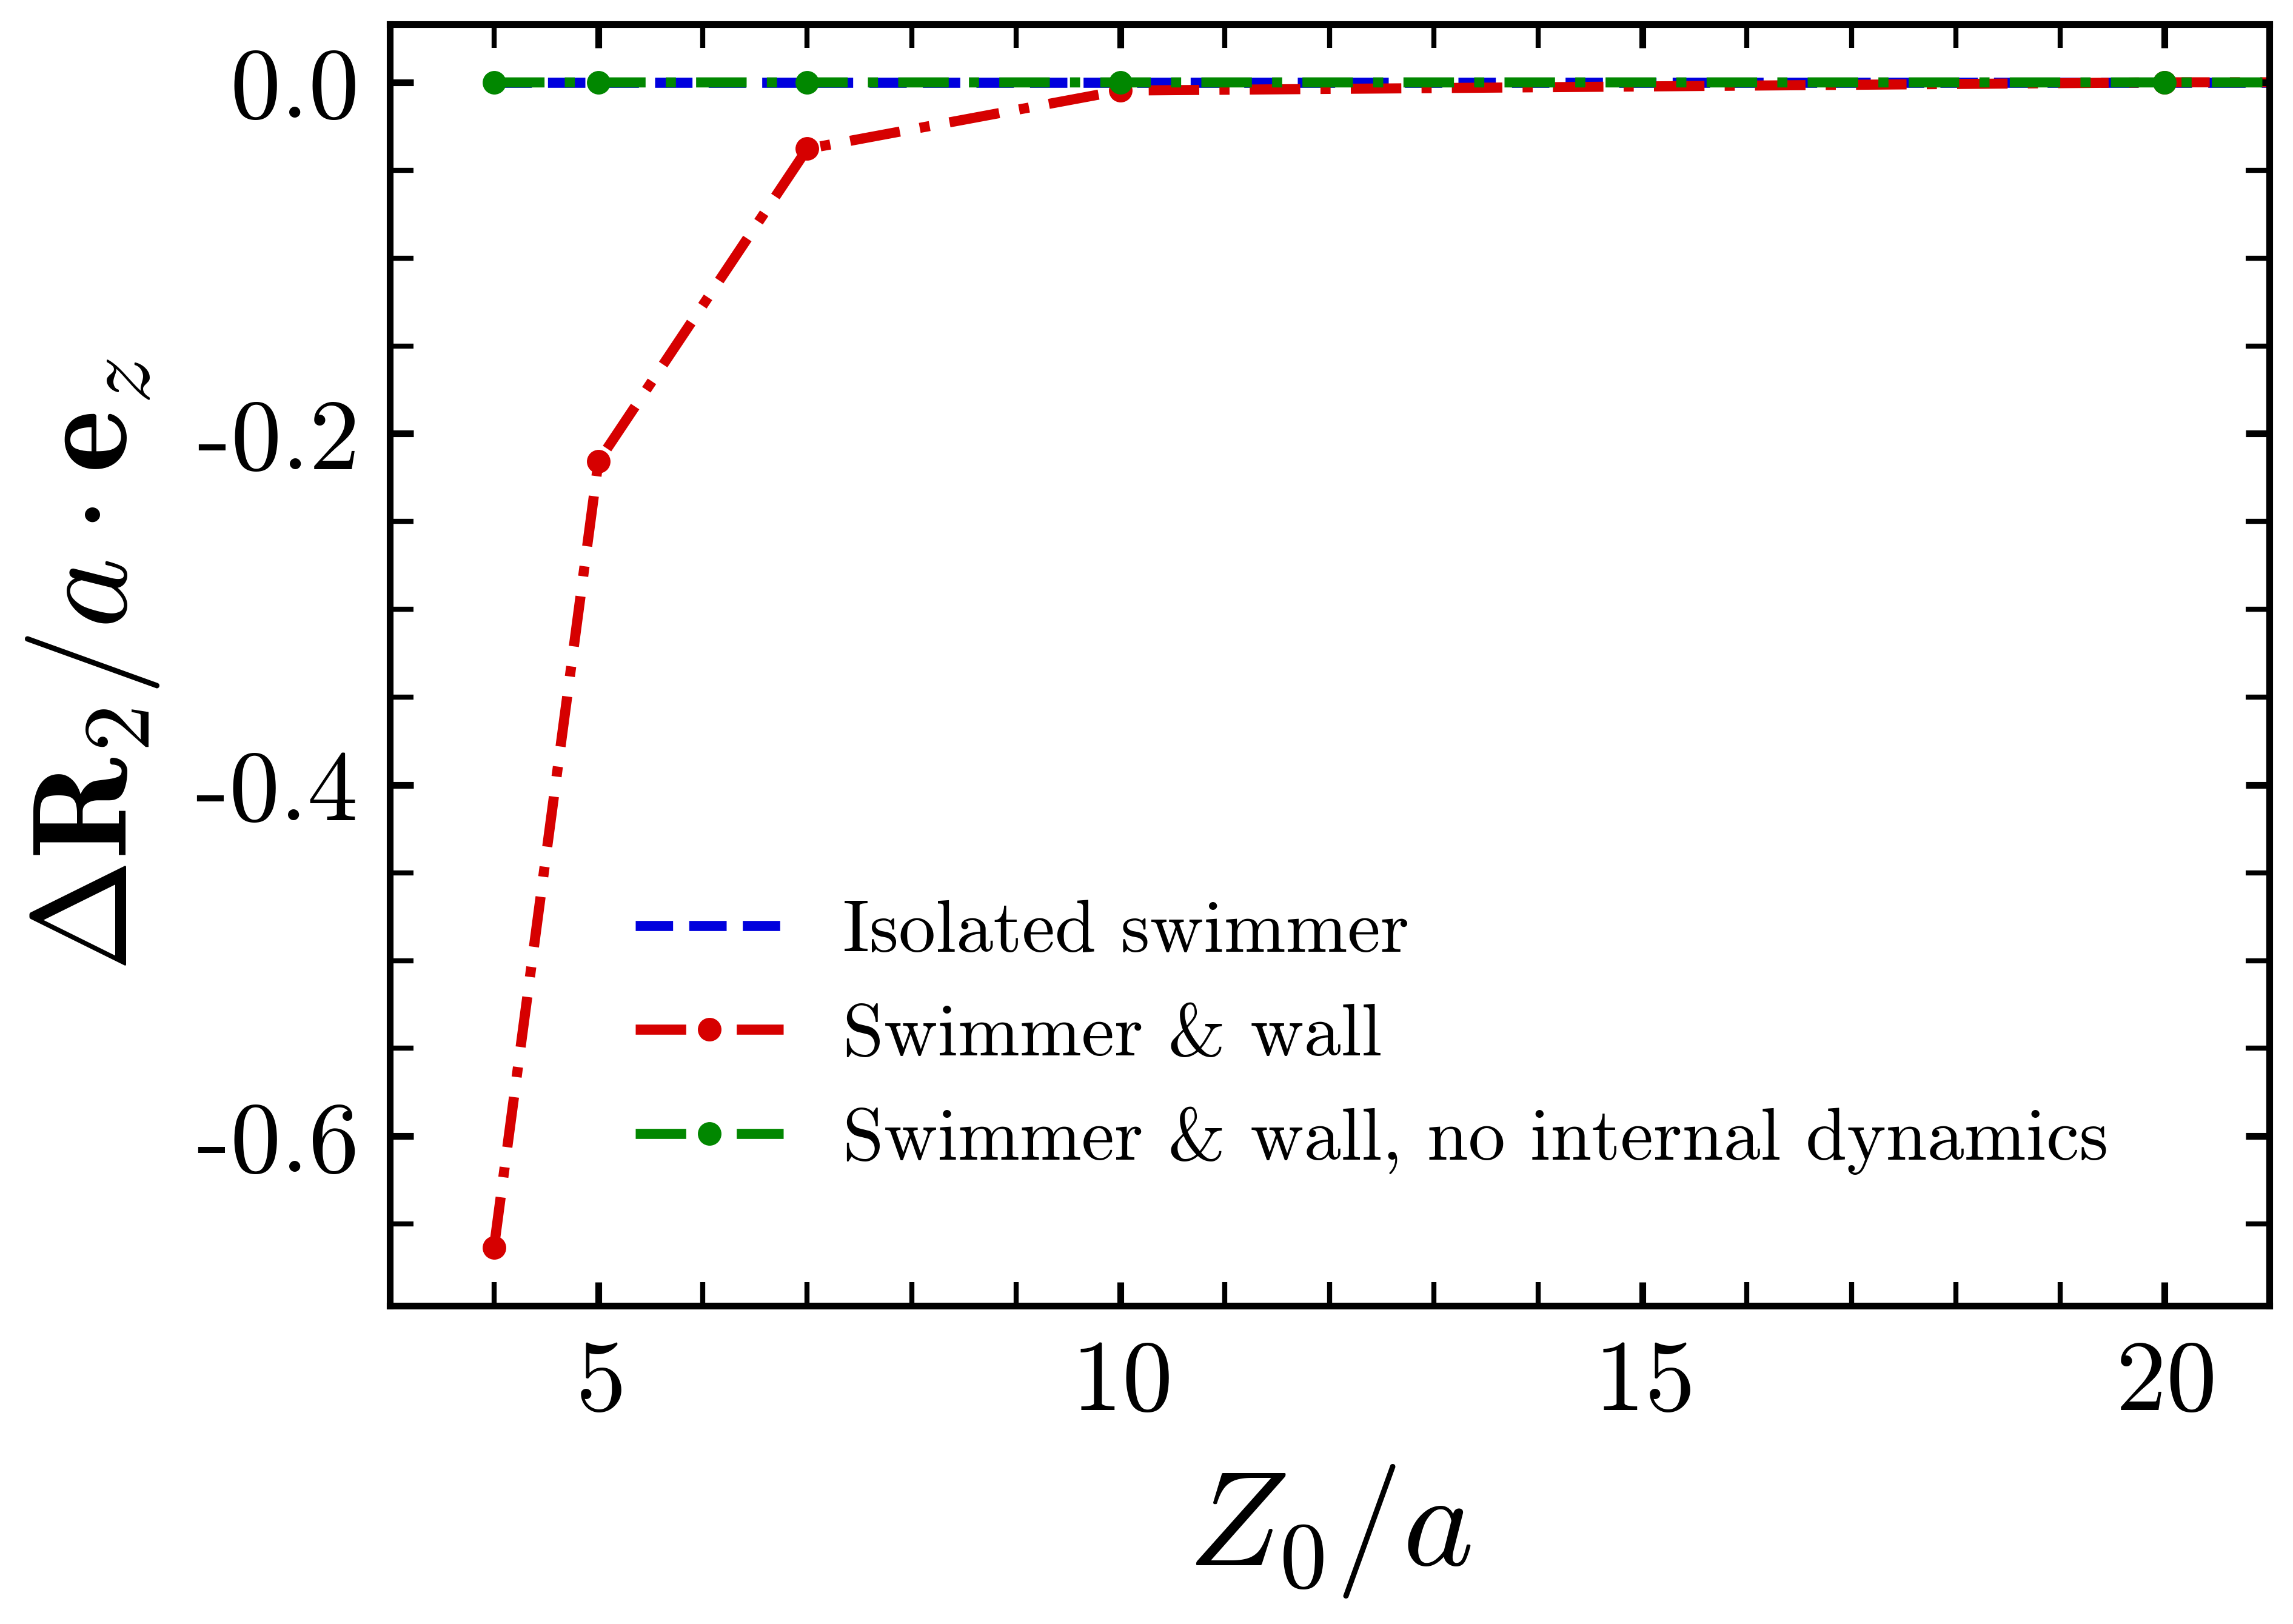

In [10]:
# Prepare data for plot
csw_noint_vary_z.sort_values(by='Z_0', inplace=True)
csw_vary_z.sort_values(by='Z_0', inplace=True)

# PLOT: CoM displacement along z-axis (initial attraction direction) for varying Z-height
numLines = 3
CoM_z_disp_plot = PlotStyling(numLines,
                              r"$Z_{0} / a$", r"$\Delta \mathbf{R}_{2} /a \cdot \mathbf{e}_{z}$",
                              title=None, loglog=False,
                              outputDir=output_dir + '/', figName="com_z_disp_comp",
                              eps=eps_output, continuousColors=False)
CoM_z_disp_plot.make_plot(showPlot=True)
CoM_z_disp_plot.curve([4.0, 200.0], [0.0, 0.0],
                      thin_curve=False, dashed_curve=True, zorder=0, label="Isolated swimmer")
CoM_z_disp_plot.scatter_dashed(csw_vary_z['Z_0'], csw_vary_z['CoM_disp_z'],
                               marker=None, zorder=1, label="Swimmer & wall")
CoM_z_disp_plot.scatter_dashed(csw_noint_vary_z['Z_0'], csw_noint_vary_z['CoM_disp_z'],
                               marker=None, zorder=2, label="Swimmer & wall, no internal dynamics")
CoM_z_disp_plot.set_major_minor_ticks(
    xMajorLoc=5, xMinorLoc=1, yMajorLoc=0.2, yMinorLoc=0.05)
CoM_z_disp_plot.ax.set_xlim([3, 21])
CoM_z_disp_plot.legend(title=None, loc='best',
                       bbox_to_anchor=(0.05, 0.05, 0.9, 0.9), ncol=1)
CoM_z_disp_plot.save_plot()

/home/aglisman/anaconda3/envs/bodies-in-potential-flow/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


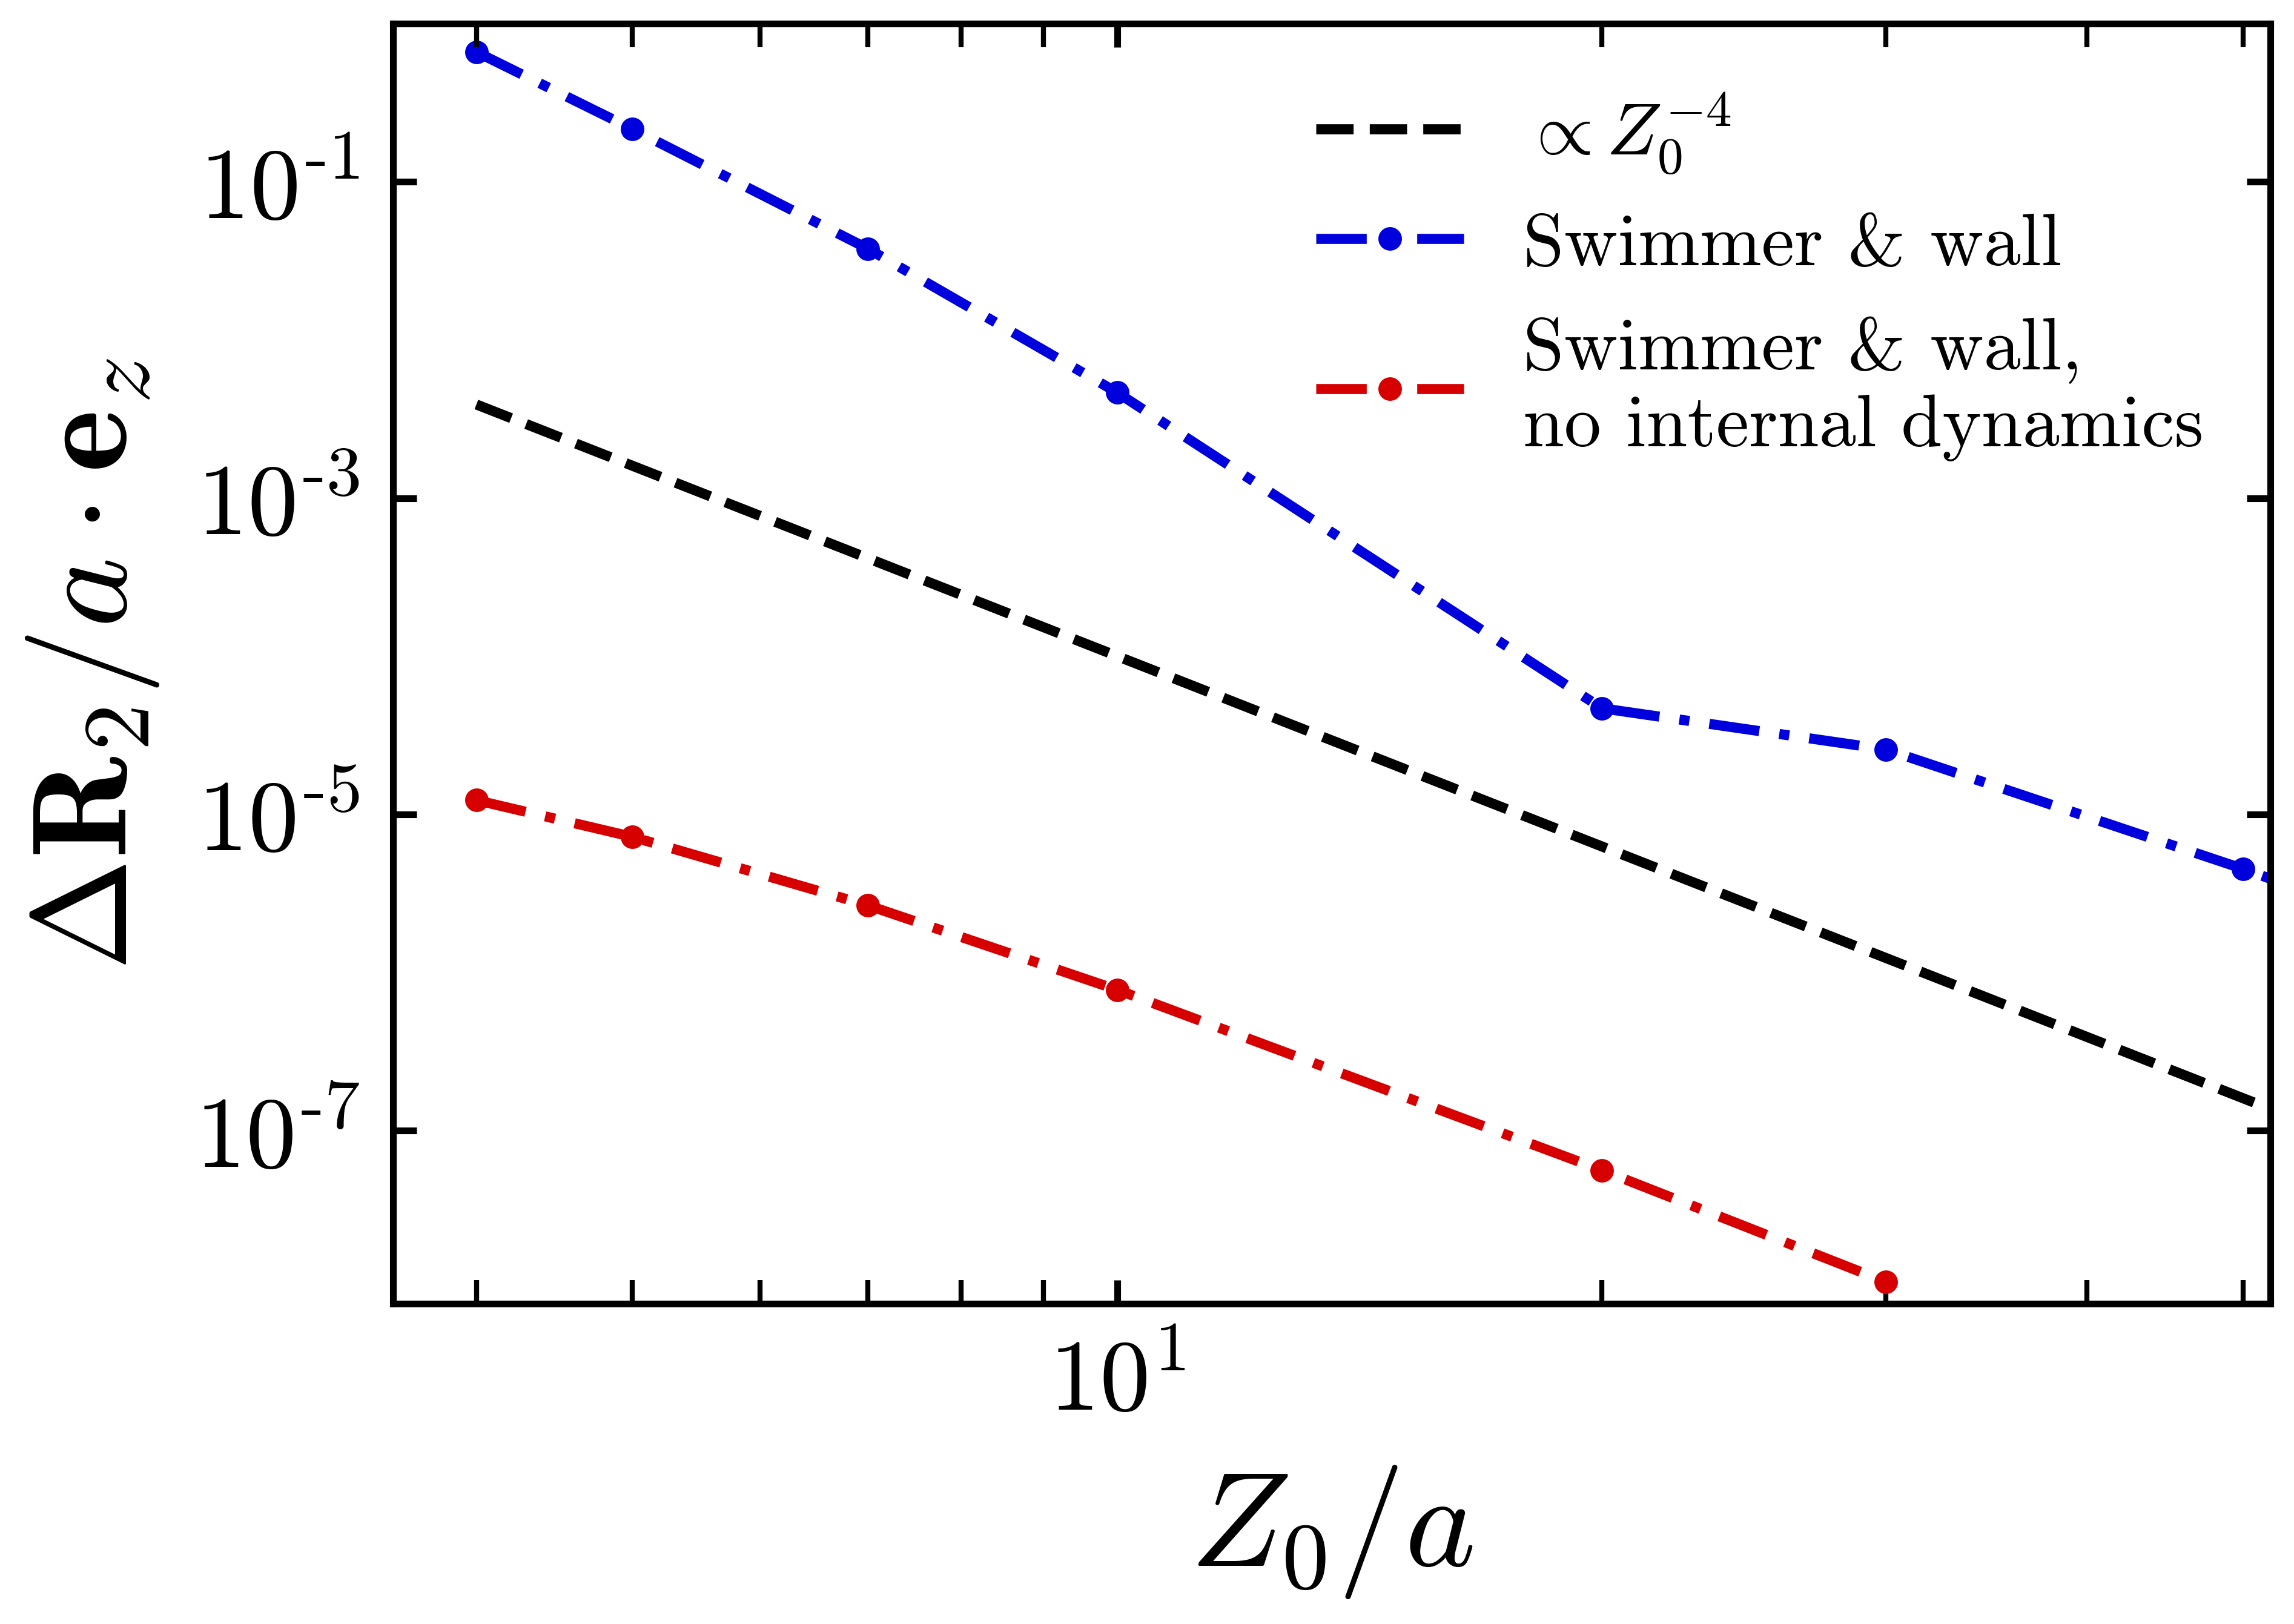

In [11]:
# Prepare data for plot
csw_noint_vary_z.sort_values(by='Z_0', inplace=True)
csw_vary_z.sort_values(by='Z_0', inplace=True)

x_val_test = np.array([4.0, 1000.0])

# PLOT: CoM displacement along z-axis (initial attraction direction) for varying Z-height
numLines = 3
CoM_z_disp_plot = PlotStyling(numLines,
                              r"$Z_{0} / a$", r"$\Delta \mathbf{R}_{2} /a \cdot \mathbf{e}_{z}$",
                              title=None, loglog=True,
                              outputDir=output_dir + '/', figName="com_z_disp_loglog_comp",
                              eps=eps_output, continuousColors=False)
CoM_z_disp_plot.make_plot(showPlot=True)
CoM_z_disp_plot.curve(x_val_test, 1 * np.power(x_val_test, -4),
                    thin_curve=False, dashed_curve=True, zorder=0, label=r"$ \propto Z_0^{-4}$", color='k')
CoM_z_disp_plot.scatter_dashed(csw_vary_z['Z_0'], np.abs(csw_vary_z['CoM_disp_z']),
                               marker=None, zorder=1, label="Swimmer & wall")
CoM_z_disp_plot.scatter_dashed(csw_noint_vary_z['Z_0'], np.abs(csw_noint_vary_z['CoM_disp_z']),
                               marker=None, zorder=2, label="Swimmer & wall, \nno internal dynamics")
# CoM_z_disp_plot.set_major_minor_ticks(
    # xMajorLoc=5, xMinorLoc=1, yMajorLoc=0.2, yMinorLoc=0.05)
CoM_z_disp_plot.ax.set_xlim([3.55, 52])
CoM_z_disp_plot.ax.set_ylim([8e-9, 1e-0])
CoM_z_disp_plot.legend(title=None, loc='best',
                       bbox_to_anchor=(0.05, 0.05, 0.95, 0.95), ncol=1)
CoM_z_disp_plot.save_plot()

/home/aglisman/anaconda3/envs/bodies-in-potential-flow/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


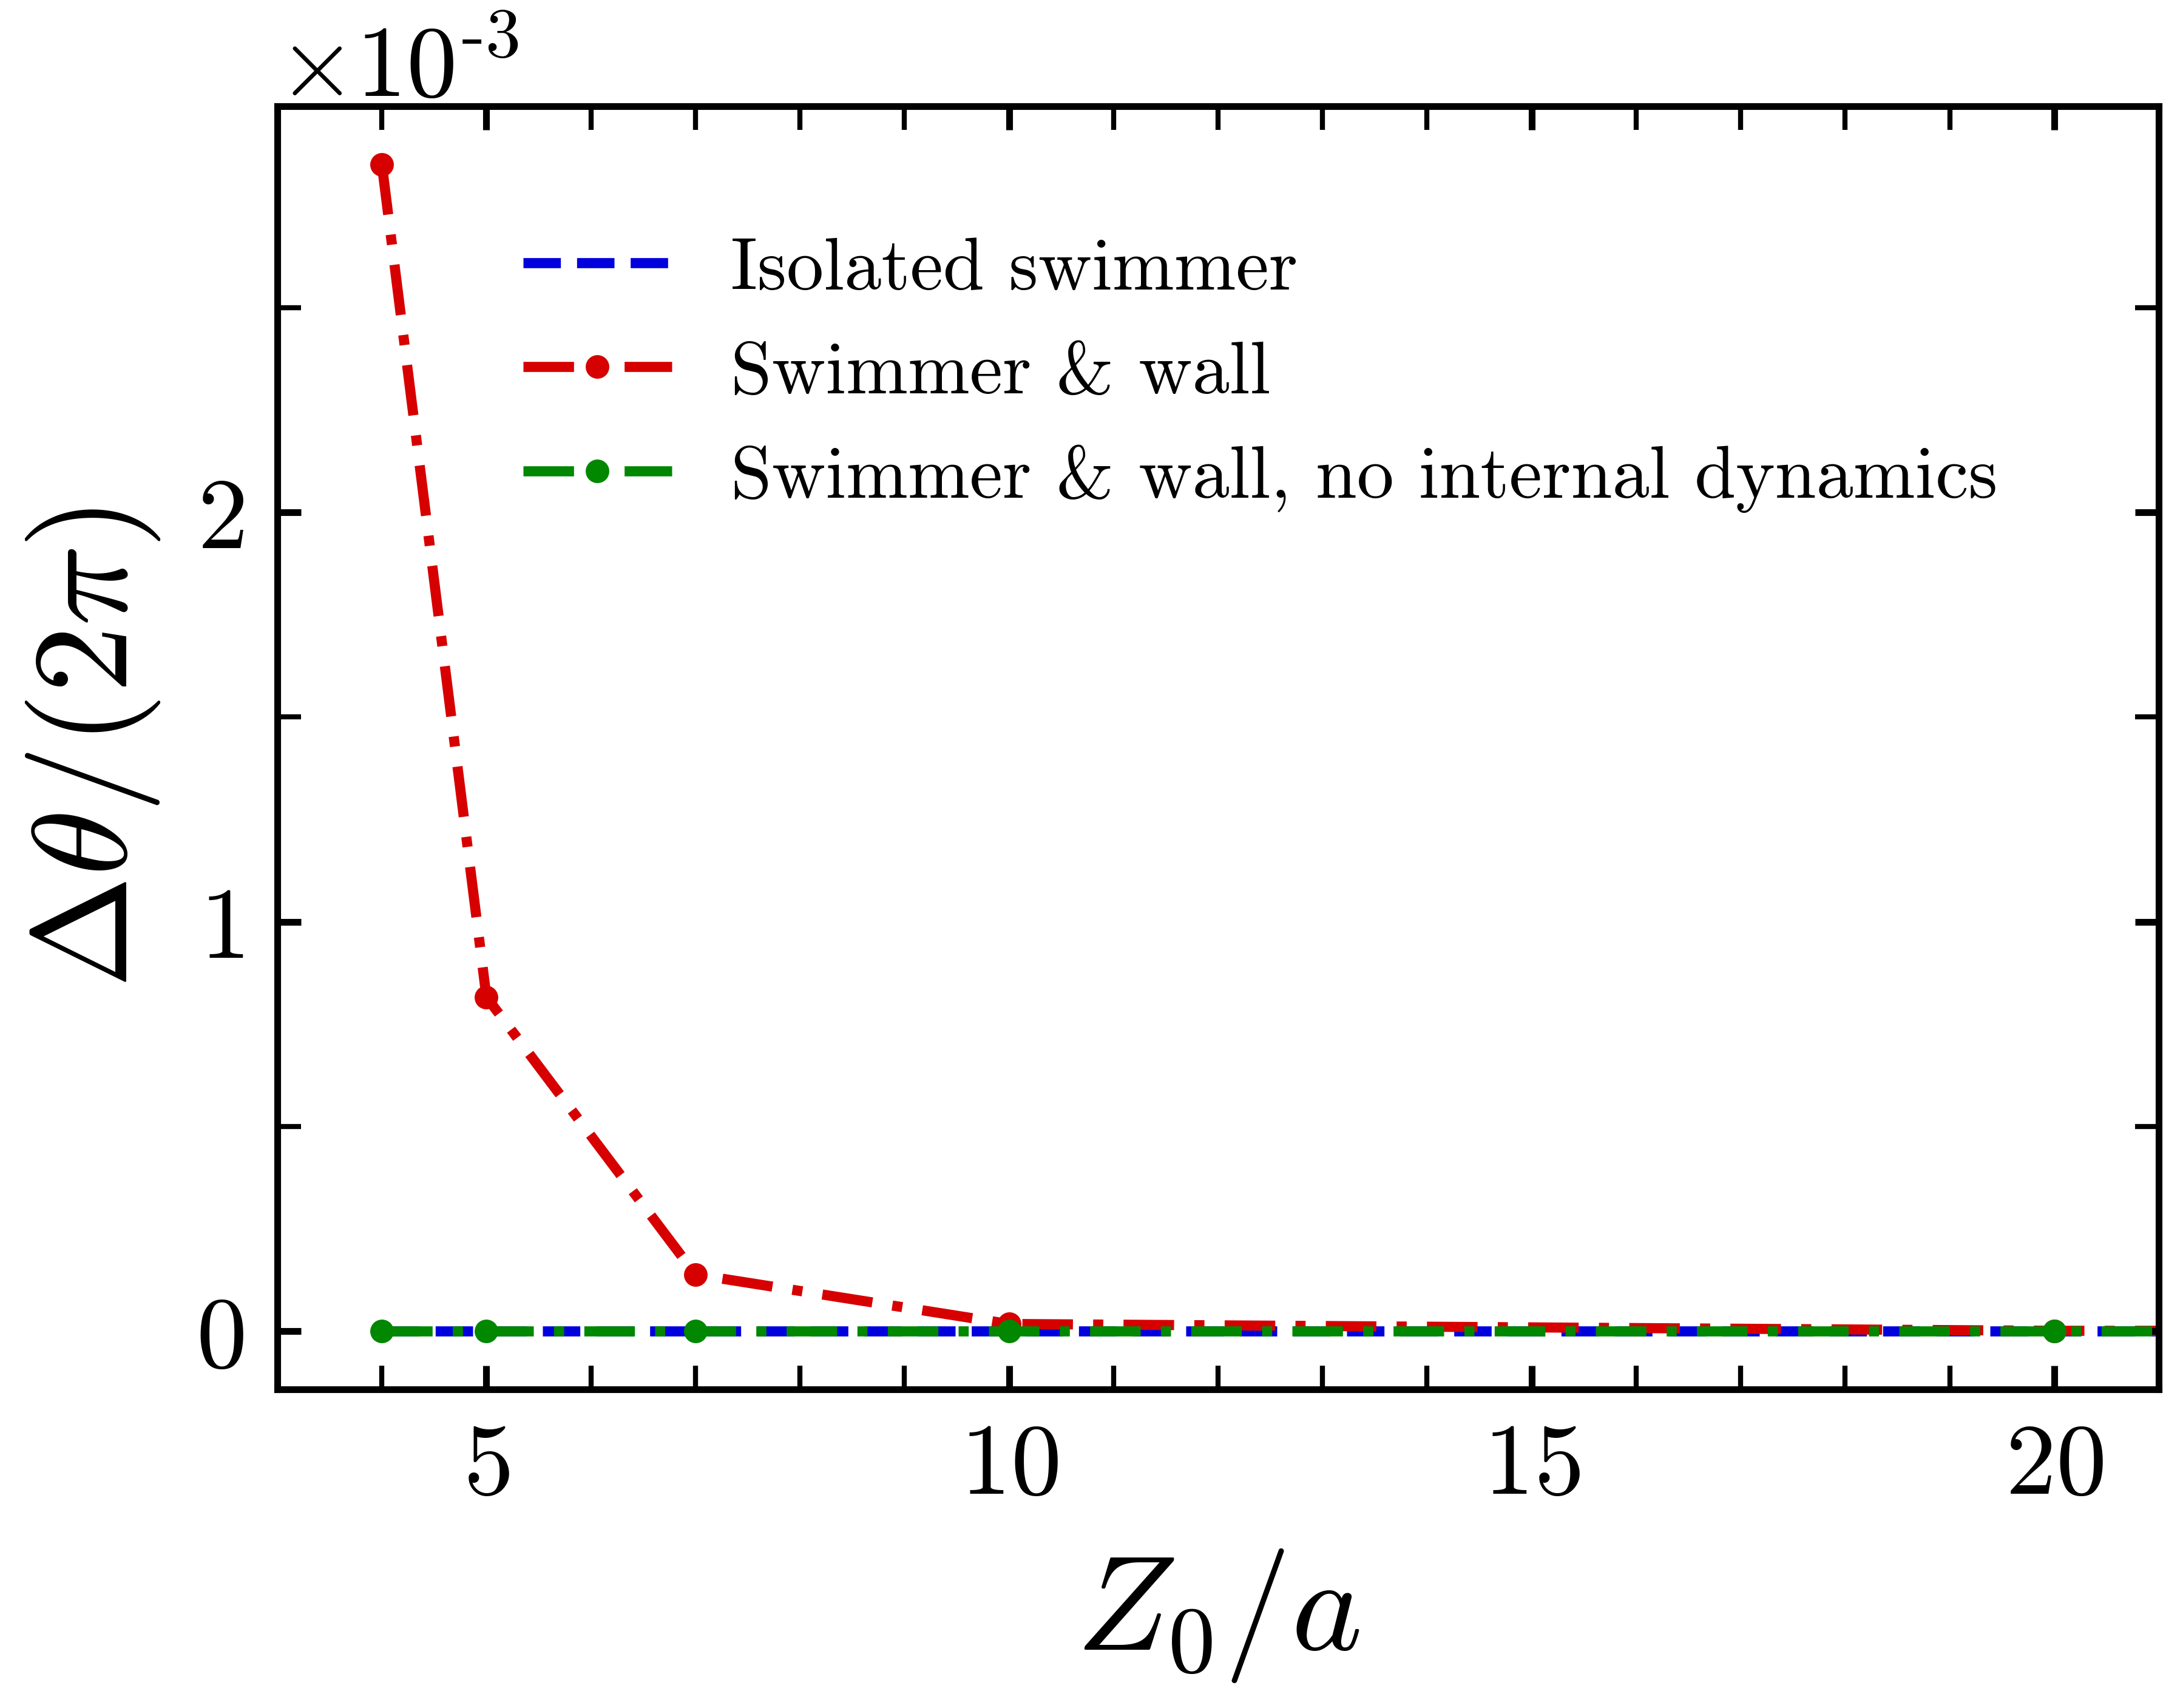

In [12]:
# Prepare data for plot
csw_noint_vary_z.sort_values(by='Z_0', inplace=True)
csw_vary_z.sort_values(by='Z_0', inplace=True)

# PLOT: CoM displacement along z-axis (initial attraction direction) for varying Z-height
numLines = 3
theta_disp_plot = PlotStyling(numLines,
                              r"$Z_{0} / a$", r"$\Delta \theta / (2 \pi)$",
                              title=None, loglog=False,
                              outputDir=output_dir + '/', figName="ang_disp_comp",
                              eps=eps_output, continuousColors=False)
theta_disp_plot.make_plot(showPlot=True)
theta_disp_plot.curve([4.0, 200.0], [0.0, 0.0],
                      thin_curve=False, dashed_curve=True, zorder=0, label="Isolated swimmer")
theta_disp_plot.scatter_dashed(csw_vary_z['Z_0'], csw_vary_z['final_theta'] / (2.0 * np.pi),
                               marker=None, zorder=1, label="Swimmer & wall")
theta_disp_plot.scatter_dashed(csw_noint_vary_z['Z_0'], csw_noint_vary_z['final_theta'] / (2.0 * np.pi),
                               marker=None, zorder=2, label="Swimmer & wall, no internal dynamics")
theta_disp_plot.set_major_minor_ticks(
    xMajorLoc=5, xMinorLoc=1, yMajorLoc=0.001, yMinorLoc=0.0005)
theta_disp_plot.ax.set_xlim([3, 21])
theta_disp_plot.set_yaxis_scientific()
theta_disp_plot.legend(title=None, loc='best',
                       bbox_to_anchor=(0.05, 0.05, 0.9, 0.9), ncol=1)
theta_disp_plot.save_plot()
